In [2]:
import os
import numpy as np

RNG = np.random.default_rng(2023)
HOME = os.getenv("HOME")

In [5]:
from dataloaders import LineReader

reader = LineReader(
    nlines=10000,
    fparams=f"{HOME}/Datasets/cell_migration/parameters.txt",
    fseries=[
        f"{HOME}/Datasets/cell_migration/dac.txt",
        f"{HOME}/Datasets/cell_migration/msd.txt"
    ],
    prepend_index=False
)

In [6]:
from bayesflow.simulation import GenerativeModel, Prior, Simulator

prior = Prior(prior_fun=reader.sample_params, param_names=["A", "B", "C", "D", "E"])
simulator = Simulator(simulator_fun=reader.simulate_series)

prior_means, prior_stds = prior.estimate_means_and_stds()

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


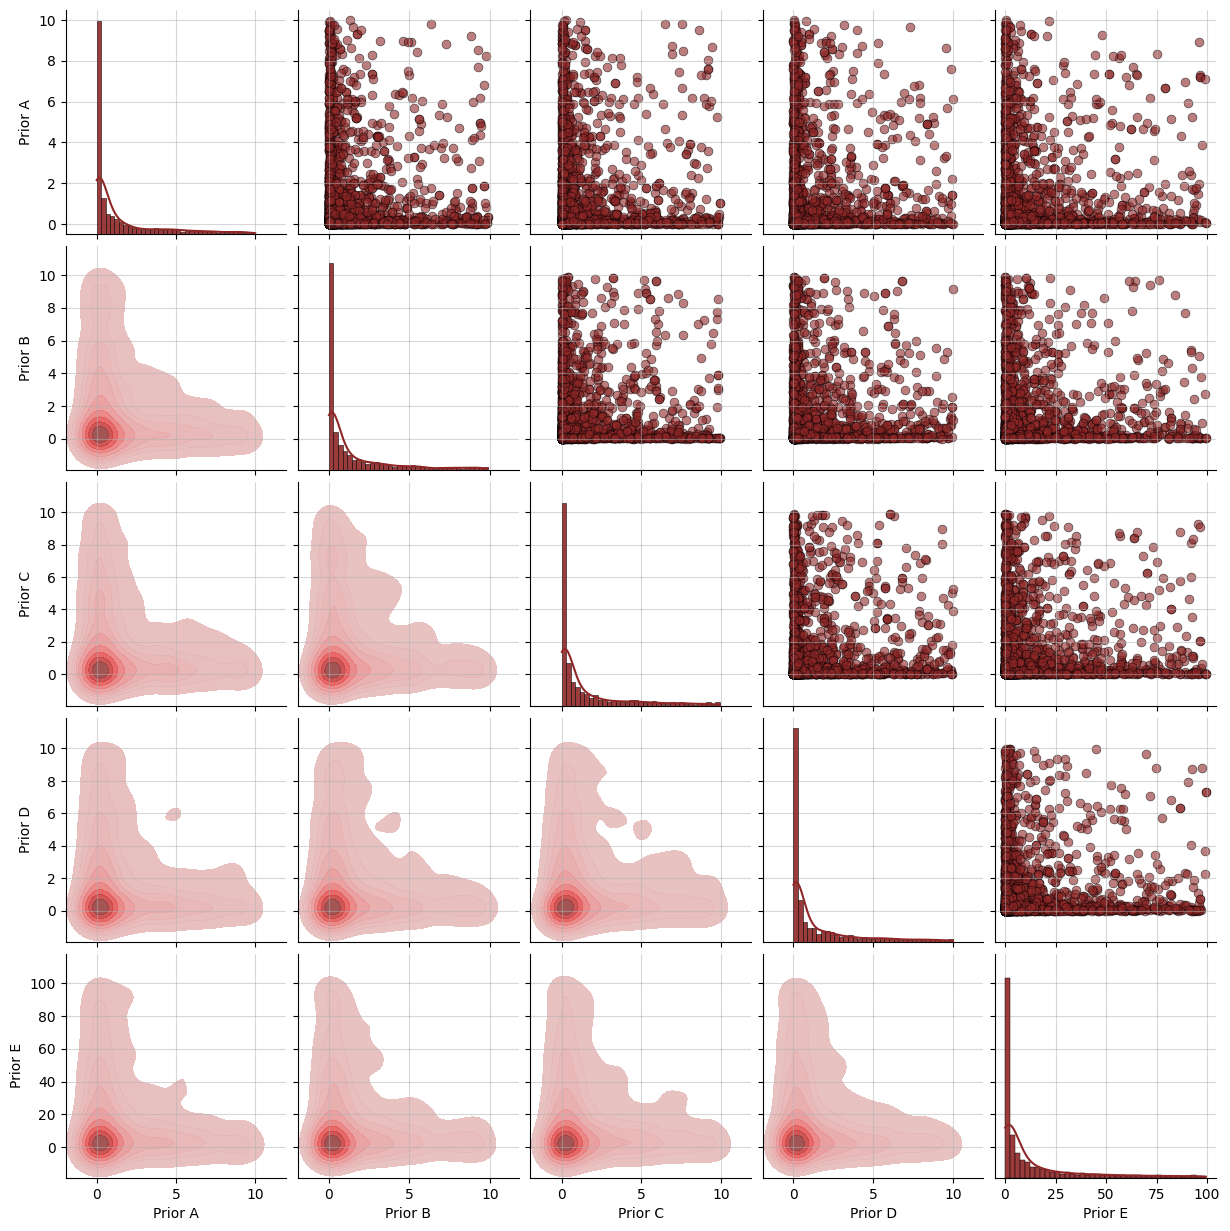

In [7]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [8]:
from bayesflow.networks import InvertibleNetwork, TimeSeriesTransformer
from bayesflow.amortizers import AmortizedPosterior

In [9]:
summary_net = TimeSeriesTransformer(input_dim=len(reader.series[0])+1)

In [10]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [11]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

In [12]:
from bayesflow.trainers import Trainer


def configure_input(input_dict):

    """ Function to configure the simulated quantities (i.e., simulator outputs)
        into a neural network-friendly (BayesFlow) format.
    """

    # Extract prior draws and z-standardize with previously computed means
    # prior draws are the parameters we want to estimate
    params = input_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    x = input_dict['sim_data']
    batch_size, _, num_timesteps  = x.shape
    # add time encoding to the data x
    time_encoding = np.linspace(0, 1, num_timesteps)
    time_encoding_batched = np.tile(time_encoding, (batch_size, 1, 1))

    return {
        "parameters": params,
        "summary_conditions": np.concatenate((x, time_encoding_batched), axis=1).reshape(batch_size, num_timesteps, -1)
    }

trainer = Trainer(amortizer=amortizer, generative_model=None, configurator=configure_input, memory=True)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


In [13]:
train, val = reader.train_val_split(0.9)

offline_data = {
    "prior_draws": train[0],
    "sim_data": train[1],
}

validation_data = {
    "prior_draws": val[0],
    "sim_data": val[1],
}

history = trainer.train_offline(offline_data, epochs=30, batch_size=64, validation_sims=validation_data)

Training epoch 1:  23%|██▎       | 65/282 [00:10<00:13, 16.38it/s, Epoch: 1, Batch: 65,Loss: 6.266,W.Decay: 0.207,Avg.Loss: 6.704,Avg.W.Decay: 0.218,LR: 5.00E-04]

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


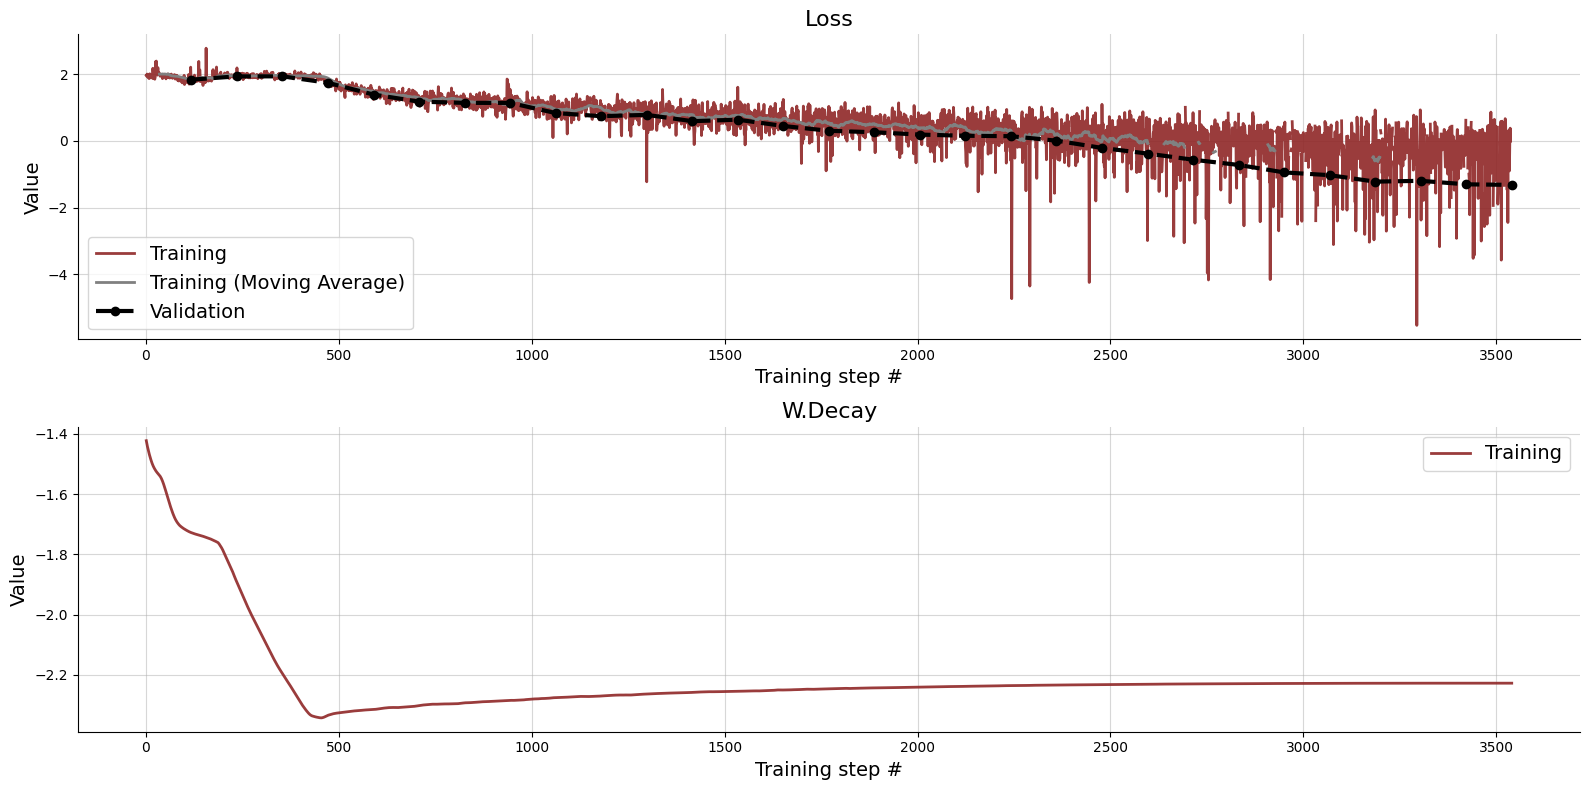

In [ ]:
import bayesflow.diagnostics as diag

f = diag.plot_losses(np.log(history["train_losses"]), np.log(history["val_losses"]), moving_average=True)

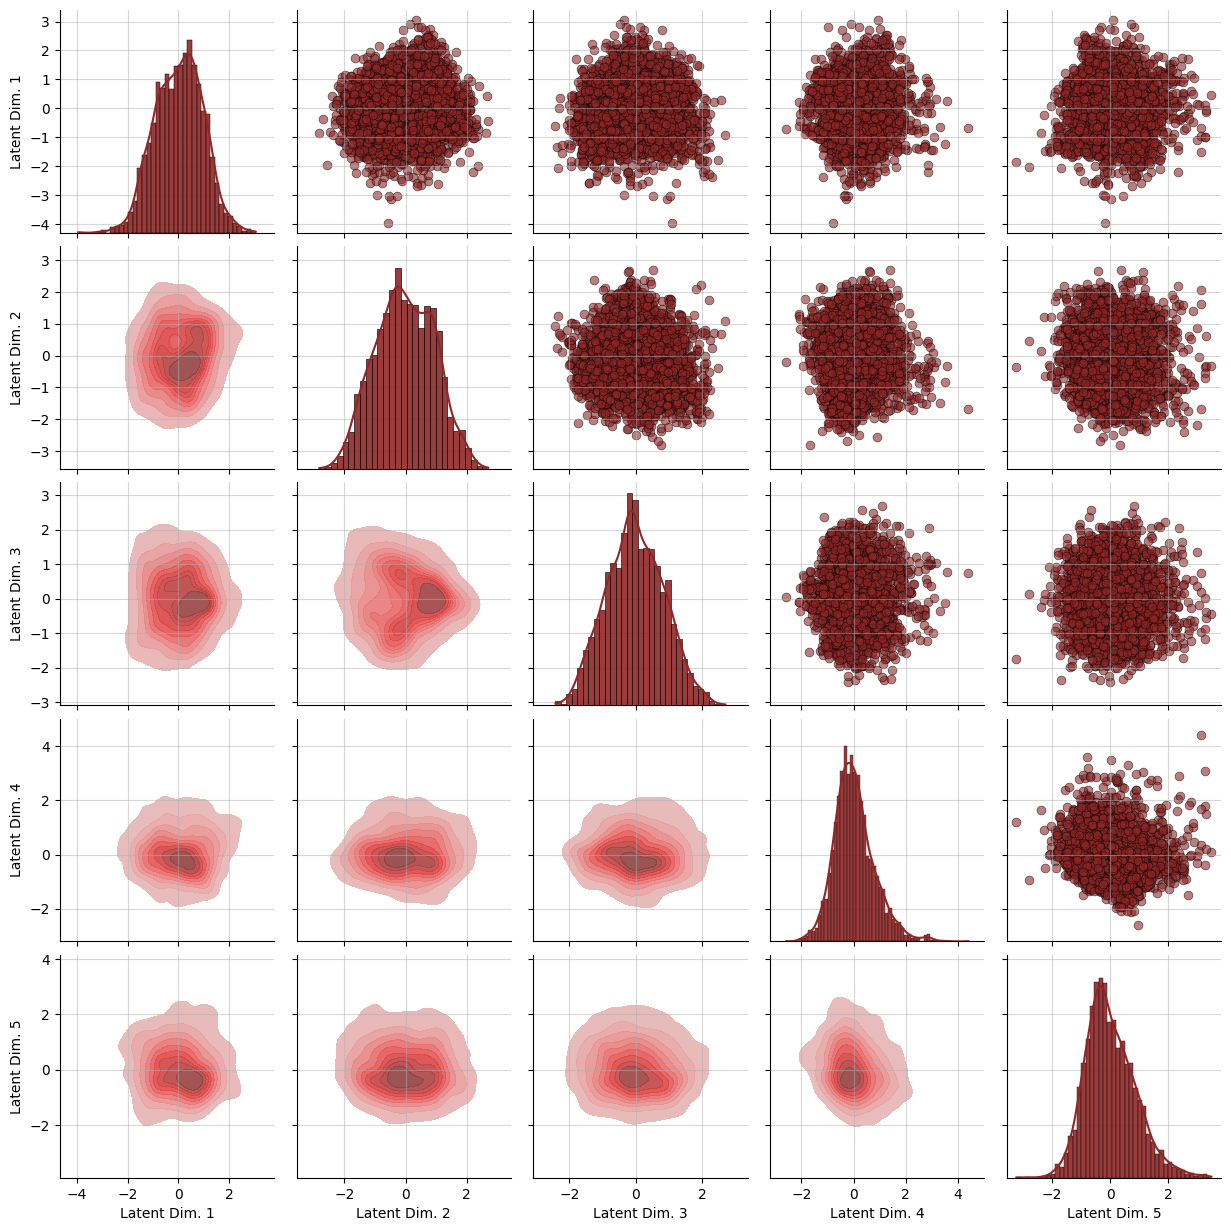

In [ ]:
f = trainer.diagnose_latent2d()

In [ ]:
# f = trainer.diagnose_sbc_histograms()

In [ ]:
validation_sims = trainer.configurator(validation_data)

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

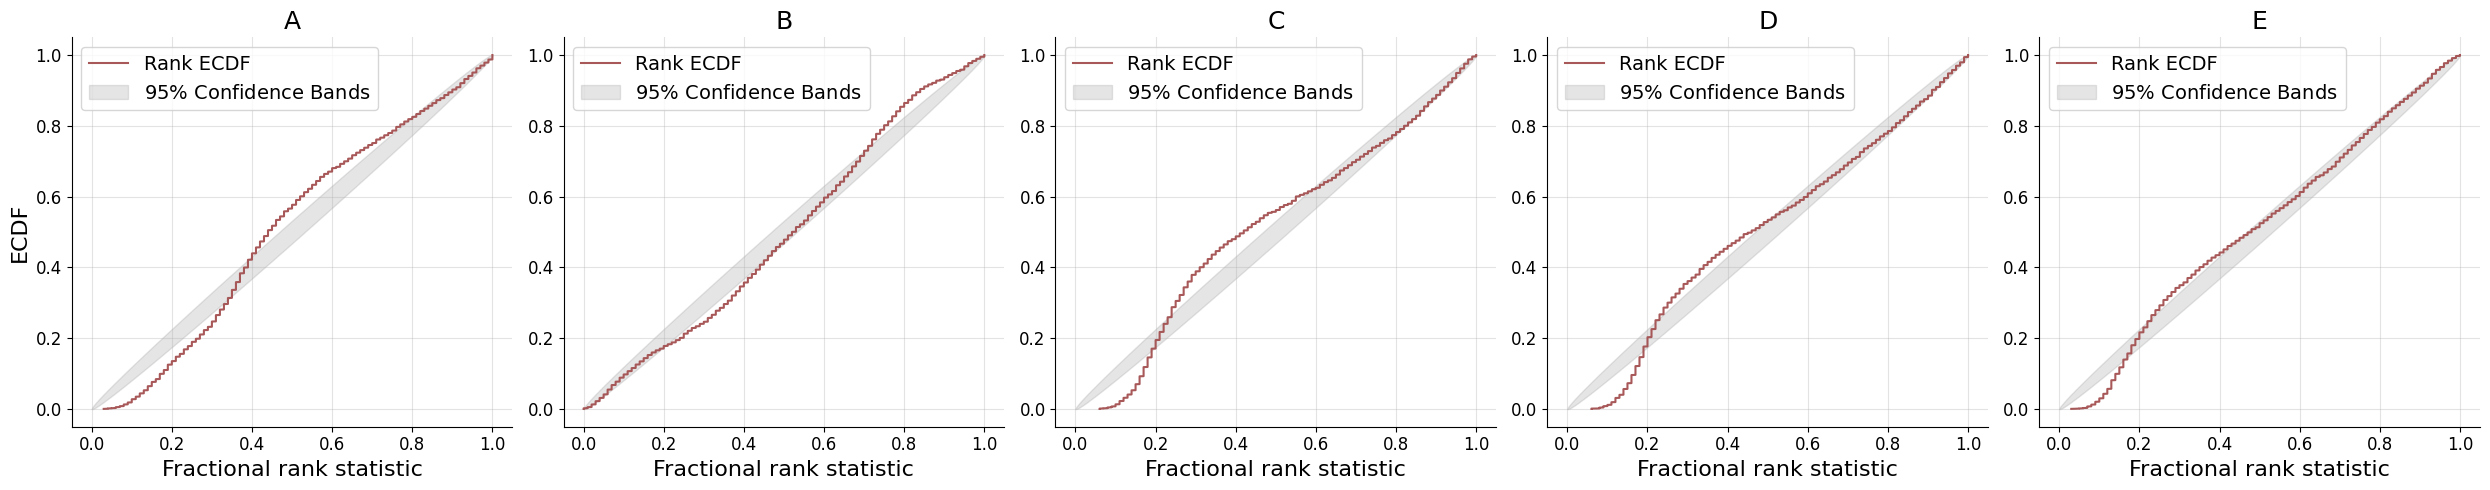

In [ ]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

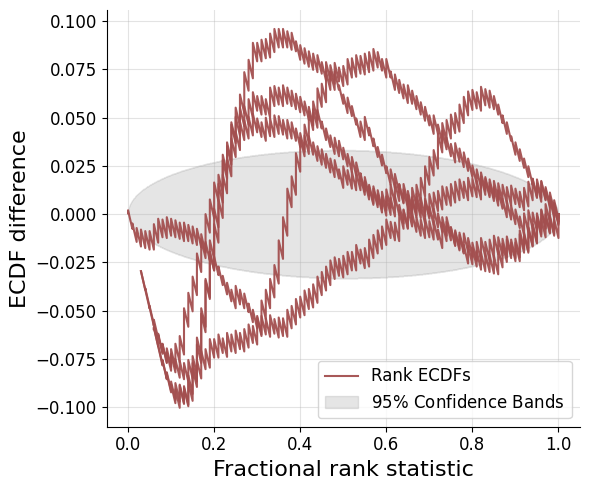

In [ ]:
f = diag.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)

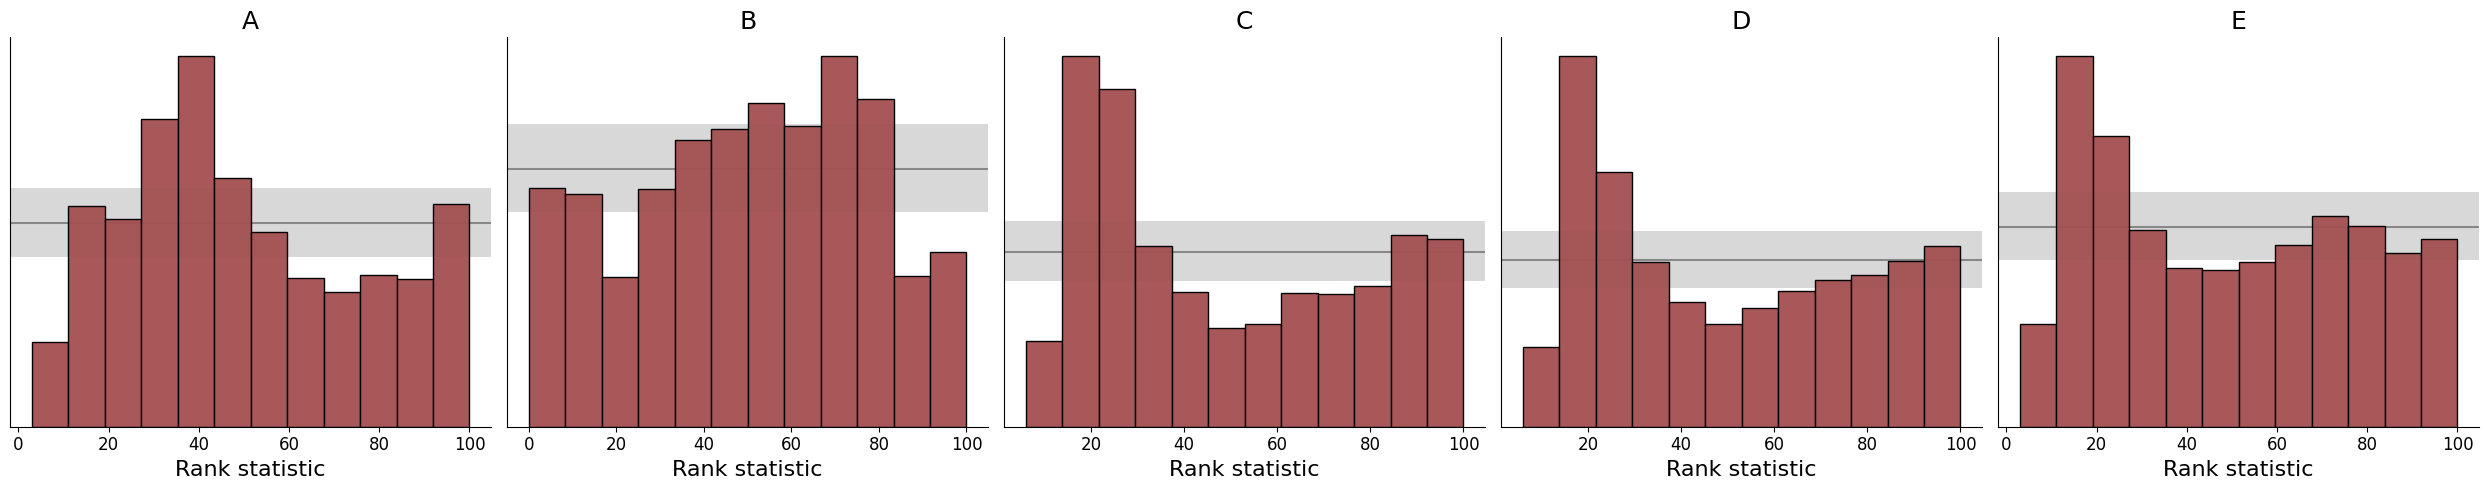

In [ ]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

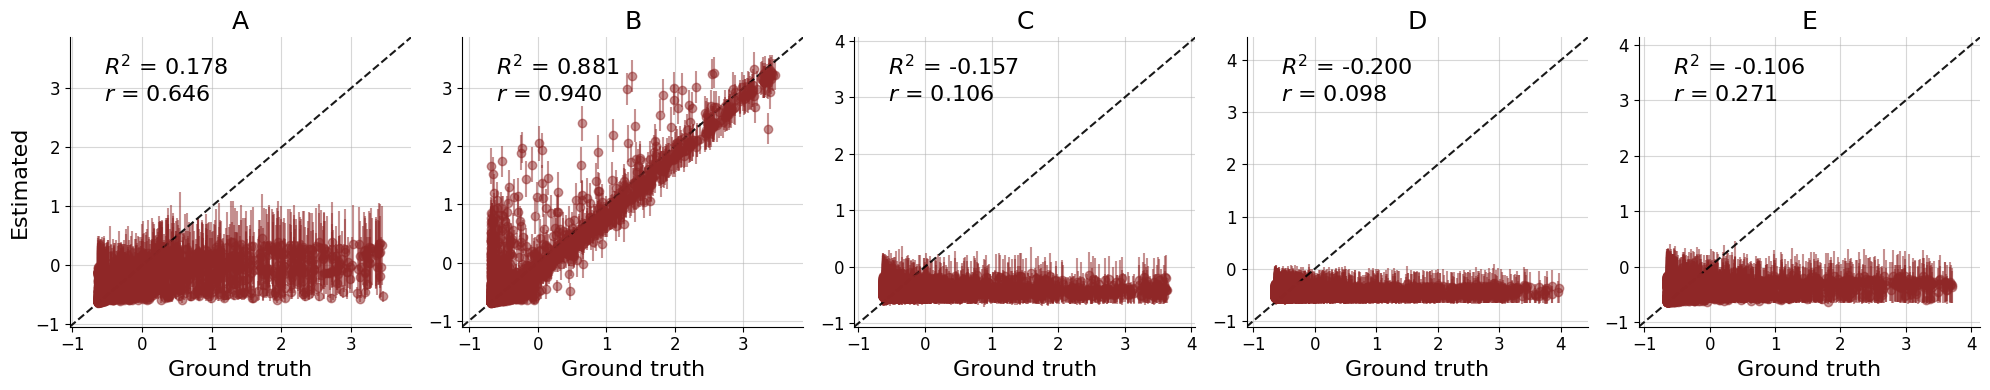

In [ ]:
from diagnostics import plot_recovery

post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)